In [1]:
# Autor: Jairo Valea López
#
# Cousiñas con machine learning aplicado á niebla do Fiouco

# Importado de librerías habituales

import os
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import time
import matplotlib
import scipy as sp
from sklearn import metrics
from IPython.utils import io
from natsort import natsorted
from IPython.display import HTML
from tqdm.notebook import tqdm, trange # barra de progreso
from matplotlib import pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance

%matplotlib notebook

def promedio(lst):
    return sum(lst) / len(lst)

In [16]:
# cargado de datos (todo.csv)

ruta_proces = 'C:\\Users\\miguel.anton\\Desktop\\NIEBLA\\Ensayos procesados\\'

carpeta = natsorted(os.listdir(ruta_proces))
procesados = []
nombres = []

# Valor máximo de visibilidad a considerar
# los algoritmos funcionan mejor con un valor máximo más bajo (100)
tope = 150

datos = pd.read_csv(ruta_proces + 'todo.csv', delimiter = ";", decimal = ".")
for i in range(len(datos)):
    if (datos.loc[i,'vis'] > tope):
        datos.loc[i,'vis'] = tope
datos = pd.get_dummies(datos, columns=["dir_v_estacion"], prefix=["dir"] )

# 
# PREDICCIÓN: INTENTAR PREDECIR LA VISIBILIDAD A PARTIR DE LOS DATOS DISPONIBLES
# USANDO DIFERENTES ALGORITMOS DE MACHINE-LEARNING:
#
# Random forest: n-ización de árboles de decisión (entiéndase como una especie de diagrama de flujo)
# Gradient booster: conjunción y retroalimentación de modelos de predicción débiles por si solos
#

posiciones = [1,3,4,5,6]
#posiciones = [1,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19]
#posiciones = [4,7] # solo D_sauter y concentración
X = datos.iloc[:, posiciones].values
y = datos.iloc[:, 10].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# evitar diferencias de escala
#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

# random forest
bosque = RandomForestRegressor(n_estimators=200,random_state=0,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
bosque.fit(X_train, y_train)
y_pred_bosque = bosque.predict(X_test)

# gradient booster
boost = AdaBoostRegressor(n_estimators=200, learning_rate=0.1,random_state=0,loss='square')
boost.fit(X_train, y_train)
y_pred_gradient = boost.predict(X_test)

print('')
print('          Bosque aleatorio:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bosque)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test)):
    print("{: >20} {: >20}".format(y_test[i], round(y_pred_bosque[i],2)))
print('')
print('')
print('               Ada booster:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_gradient)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test)):
    print("{: >20} {: >20}".format(y_test[i], round(y_pred_gradient[i],2)))


          Bosque aleatorio:

Root Mean Squared Error: 29.25
           visi real     -      visi pred
                24.0                31.44
                27.0                34.01
               114.0               101.71
                35.0                24.65
                87.0               122.48
                40.0                90.41
                18.0                24.66
                73.0                70.86
                97.0                27.59
               119.0                92.75
               150.0               148.87
                35.0                46.34
                38.0                28.98
                20.0                21.82
                83.0               116.79
               109.0               119.26
               150.0               131.47
               150.0                 40.4
                39.0                43.99
                37.0                46.97
                41.0                30.95
               

In [17]:
s_bosque = cross_val_score(bosque, X, y, cv=10, scoring='neg_root_mean_squared_error')
s_boost = cross_val_score(boost, X, y, cv=10, scoring='neg_root_mean_squared_error')

print('Al bosque aleatorio le importan las siguientes variables:') # 30.94 con todas  30.50 sin viento y dmedio
                                                                    # 30.24 con solo dsauter, d10, d90 y temp
                                                                    # 29.53 con solo dsauter, d10, d90 y dmedio
                                                                    # 28.13 añadiendo día del año
print("%0.2f accuracy with a standard deviation of %0.2f" % (s_bosque.mean(), s_bosque.std()))
print('')
r = permutation_importance(bosque, X_test, y_test, n_repeats=20, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{datos.columns[posiciones[i]]:<12}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
print('')
print('Al Ada booster le importan las siguientes variables:')
print("%0.2f accuracy with a standard deviation of %0.2f" % (s_boost.mean(), s_boost.std()))
print('')
r = permutation_importance(boost, X_test, y_test, n_repeats=20, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{datos.columns[posiciones[i]]:<12}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

Al bosque aleatorio le importan las siguientes variables:
-28.13 accuracy with a standard deviation of 12.18

d_sauter    0.830 +/- 0.215
dia         0.152 +/- 0.048
d10         0.033 +/- 0.027
d_medio     0.022 +/- 0.023
d90         0.004 +/- 0.023

Al Ada booster le importan las siguientes variables:
-31.72 accuracy with a standard deviation of 9.69

d_sauter    0.859 +/- 0.213
dia         0.178 +/- 0.056
d10         0.055 +/- 0.029
d90         0.024 +/- 0.034
d_medio     -0.015 +/- 0.016


<IPython.core.display.Javascript object>


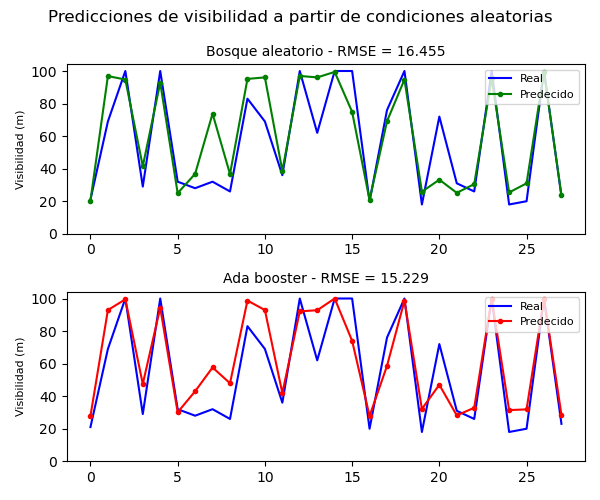

In [15]:
equis = range(len(y_test))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,5))

plt.suptitle("Predicciones de visibilidad a partir de condiciones aleatorias")

ax1.plot(equis,y_test, color = "blue",label="Real")
ax1.plot(equis, y_pred_bosque, color = "green", marker = ".",label="Predecido")
ax1.set_ylim(bottom=0)
ax1.set_ylabel("Visibilidad (m)",size=8)
ax1.set_title('Bosque aleatorio - RMSE = ' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bosque)),3)),size=10)
ax1.legend(loc="upper right",prop={'size': 8})

ax2.plot(equis,y_test, color = "blue",label="Real")
ax2.plot(equis, y_pred_gradient, color = "red", marker = ".",label="Predecido")
ax2.set_ylim(bottom=0)
ax2.set_ylabel("Visibilidad (m)",size=8)
ax2.set_title('Ada booster - RMSE = ' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_gradient)),3)),size=10)
ax2.legend(loc="upper right",prop={'size': 8})

fig.tight_layout()
plt.show()

In [293]:
#
# A partir exclusivamente de la granulometría:
#

tope = 150

for i in range(len(procesados_total)):
    if (procesados_total.loc[i,'Visibilidad corregida (m)'] > tope):
        procesados_total.loc[i,'Visibilidad corregida (m)'] = tope

posiciones = [18,22,26,30,34,38,42,46,50,54,58,62,66,70,74]
#posiciones = np.linspace(25,75,26)
#posiciones = np.linspace(1,75,38)
#posiciones2 = np.linspace(1,75,75) # todo
X2 = procesados_total.iloc[:, posiciones2].values
y2 = procesados_total.iloc[:, procesados_total.shape[1]-1].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3)

sc = StandardScaler()
X_train2 = sc.fit_transform(X_train2)
X_test2 = sc.transform(X_test2)

# random forest
bosque2 = RandomForestRegressor(n_estimators=200,random_state=0,min_samples_split=5,min_samples_leaf=2,max_depth=50,bootstrap=True)
bosque2.fit(X_train2, y_train2)
y_pred2 = bosque2.predict(X_test2)

print('')
print('          Bosque aleatorio:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test2, y_pred2)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test2)):
    print("{: >20} {: >20}".format(y_test2[i], round(y_pred2[i],2)))
print('')


          Bosque aleatorio:

Root Mean Squared Error: 21.655
           visi real     -      visi pred
                60.0                51.96
                31.0                50.81
                75.0                98.86
                54.0                56.14
                39.0                49.62
                32.0                32.66
               150.0                150.0
               150.0               147.21
                30.0                28.42
               150.0               119.63
                51.0                80.42
                18.0                21.59
                42.0                49.01
                20.0                21.55
               150.0                89.61
                30.0                26.86
               150.0               149.43
                20.0                20.55
                66.0                62.26
                20.0                29.01
                20.0                20.38
              

In [294]:
s_granos = cross_val_score(bosque2, X2, y2, cv=10, scoring='neg_root_mean_squared_error')
print("%0.2f accuracy with a standard deviation of %0.2f" % (s_granos.mean(), s_granos.std()))
print('')
print('Al bosque aleatorio le importan las siguientes variables:')
print('')
r = permutation_importance(bosque2, X_test2, y_test2, n_repeats=20, random_state=0)
for i in r.importances_mean.argsort()[::-1]:
    print(f"{procesados_total.columns[posiciones2[i]]:<12}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")
print('')

-32.08 accuracy with a standard deviation of 9.37

Al bosque aleatorio le importan las siguientes variables:

0.407       0.162 +/- 0.017
0.898       0.049 +/- 0.008
7.779       0.042 +/- 0.004
LWC (g/m3)  0.034 +/- 0.006
8.983       0.027 +/- 0.003
8.359       0.026 +/- 0.003
Cn(P/cm3)   0.024 +/- 0.006
1.037       0.022 +/- 0.003
9.653       0.018 +/- 0.003
0.836       0.015 +/- 0.005
0.437       0.013 +/- 0.004
11.147      0.010 +/- 0.002
1.115       0.009 +/- 0.002
5.833       0.009 +/- 0.003
7.239       0.008 +/- 0.002
10.373      0.008 +/- 0.002
1.287       0.006 +/- 0.001
18.446      0.006 +/- 0.002
0.47        0.006 +/- 0.003
0.724       0.005 +/- 0.002
6.268       0.005 +/- 0.002
5.428       0.004 +/- 0.001
6.736       0.004 +/- 0.001
14.865      0.004 +/- 0.001
1.383       0.004 +/- 0.001
0.965       0.004 +/- 0.001
1.486       0.004 +/- 0.001
11.979      0.004 +/- 0.001
0.778       0.003 +/- 0.001
12.872      0.003 +/- 0.001
3.788       0.003 +/- 0.002
1.982       0.003 +/- 

<ipython-input-294-3fb8d2f779fa>:8: FutureWarning: Indexing with a float is deprecated, and will raise an IndexError in pandas 2.0. You can manually convert to an integer key instead.
  print(f"{procesados_total.columns[posiciones2[i]]:<12}"


<IPython.core.display.Javascript object>


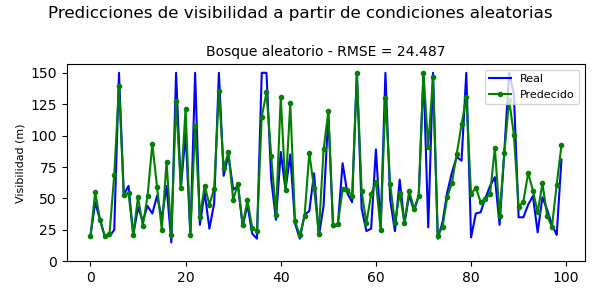

In [259]:
equis = range(len(y_test2))

fig2, ax = plt.subplots(1,1, figsize=(6,3))

plt.suptitle("Predicciones de visibilidad a partir de condiciones aleatorias")

ax.plot(equis[0:100],y_test2[0:100], color = "blue",label="Real")
ax.plot(equis[0:100], y_pred2[0:100], color = "green", marker = ".",label="Predecido")
ax.set_ylim(bottom=0)
ax.set_ylabel("Visibilidad (m)",size=8)
ax.set_title('Bosque aleatorio - RMSE = ' + str(round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bosque)),3)),size=10)
ax.legend(loc="upper right",prop={'size': 8})

fig2.tight_layout()
plt.show()

In [238]:
#
# Aún sin trabajar
#
# CLASIFICACIÓN: CLASIFICAR LAS "NIEBLAS-FIOUCO" EN CLUSTERS
# USANDO DIFERENTES ALGORITMOS DE MACHINE-LEARNING:
# 
# K-means clustering: 
#

# cargado de datos (ensayos procesados)
# OBLIGATORIO

ruta_proces = 'C:\\Users\\miguel.anton\\Desktop\\NIEBLA\\Ensayos procesados\\'

carpeta = natsorted(os.listdir(ruta_proces))
procesados = []
nombres = []

datos = pd.read_csv(ruta_proces + 'todo.csv', delimiter = ";", decimal = ".")
datos = pd.get_dummies(datos, columns=["dir_v_estacion"], prefix=["dir"] )
for i in range(len(datos)):
    if (datos.loc[i,'vis'] > 200):
        datos.loc[i,'vis_cat'] = 4
    if (200.01 > datos.loc[i,'vis'] > 100):
        datos.loc[i,'vis_cat'] = 3
    if (100.01 > datos.loc[i,'vis'] > 60):
        datos.loc[i,'vis_cat'] = 2
    if (60.01 > datos.loc[i,'vis'] > 30):
        datos.loc[i,'vis_cat'] = 1
    if (30.01 > datos.loc[i,'vis']):
        datos.loc[i,'vis_cat'] = 0

In [239]:
X = datos.iloc[:, [2,3,4,5,6,8,9,10,11,12,13,14,15]].values
y = datos.iloc[:, 16].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# evitar diferencias de escala
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# random forest
bosque = RandomForestClassifier(n_estimators=50, random_state=0)
bosque.fit(X_train, y_train)
y_pred_bosque = bosque.predict(X_test)

# gradient booster
boost = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1,
                                max_depth=5, random_state=0)
boost.fit(X_train, y_train)
y_pred_gradient = boost.predict(X_test)

print('')
print('          Bosque aleatorio:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_bosque)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test)):
    print("{: >20} {: >20}".format(y_test[i], round(y_pred_bosque[i],2)))
print('')
print('')
print('          Gradient booster:')
print('')
print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_gradient)),3))
print('           visi real     -      visi pred')
for i in range(len(y_test)):
    print("{: >20} {: >20}".format(y_test[i], round(y_pred_gradient[i],2)))


          Bosque aleatorio:

Root Mean Squared Error: 0.4
           visi real     -      visi pred
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   1                    0
                   0                    0
                   1                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   0                    0
                   1                    0
                   1                    0
                   0                    0
                   0                    0
                 